## Задание
Эксперимент проходил с 2023-01-31 по 2023-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы.  
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.  
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.  
Ваша задача — проанализировать данные АB-теста. 

1. Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
# импорт библиотек

import pandahouse
import seaborn as sns
from scipy import stats
from random import sample
import numpy as np

In [2]:
# для соединения с БД

connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': '************',
'user': '********',
'database': 'simulator_20230220'
}

In [3]:
# достаем пользователей и их характеристики из 2 группы

q_users_2_group = """
SELECT
    exp_group, 
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM 
    simulator_20230220.feed_actions 
WHERE 
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group = 2
GROUP BY 
    exp_group,
    user_id
"""

users_2_group_df = pandahouse.read_clickhouse(q_users_2_group, connection=connection)

users_2_group_df.head()

,exp_group,user_id,likes,views,ctr
0,2,131473,14,134,0.104478
1,2,23985,7,87,0.080460
2,2,24523,11,101,0.108911
3,2,32420,26,128,0.203125
4,2,24239,40,90,0.444444


In [4]:
# смотрим общее описание полученного датафрейма

users_2_group_df.describe()

,exp_group,user_id,likes,views,ctr
count,9952.0,9952.000000,9952.000000,9952.000000,9952.000000
mean,2.0,75142.800543,13.101387,66.148513,0.214419
std,0.0,53315.378033,11.838030,45.151210,0.144180
min,2.0,220.000000,0.000000,1.000000,0.000000
25%,2.0,21904.250000,5.000000,32.000000,0.095238
50%,2.0,109112.500000,9.000000,56.000000,0.142857
75%,2.0,126228.250000,17.000000,91.000000,0.325000
max,2.0,141164.000000,95.000000,321.000000,0.923077


In [5]:
# достаем пользователей и их характеристики из 1 группы (контрольная группа)

q_users_1_group = """
SELECT 
    exp_group, 
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM 
    simulator_20230220.feed_actions 
WHERE 
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group = 1
GROUP BY
    exp_group,
    user_id
"""

users_1_group_df = pandahouse.read_clickhouse(q_users_1_group, connection=connection)

users_1_group_df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [6]:
# смотрим общее описание полученного датафрейма

users_1_group_df.describe()

,exp_group,user_id,likes,views,ctr
count,10079.0,10079.000000,10079.000000,10079.000000,10079.000000
mean,1.0,75540.955948,13.792142,66.299831,0.215605
std,0.0,53211.834816,9.798990,45.043411,0.084160
min,1.0,206.000000,0.000000,2.000000,0.000000
25%,1.0,22227.000000,7.000000,32.000000,0.160097
50%,1.0,109360.000000,12.000000,56.000000,0.203125
75%,1.0,126200.500000,19.000000,90.000000,0.257654
max,1.0,140500.000000,81.000000,311.000000,0.722222


**В группах 2 и 1 приблизительно одинаковое количество пользователей и близкие значения средних CTR, однако значения стандартного отклонения и медианы ключевой метрики (CTR) отличаются.   
Тем не менее...  
Нулевая гипотеза (Н0): Новый алгоритм рекомендаций не привел к изменению поведения пользователей, CTR в группах 1 и 2 приблизительно одинаковые.  
Альтернативная гипотеза (Н1): Новый алгоритм рекомендаций привел к изменению поведения пользователей, CTR в группах 1 и 2 имеют значимые отличия.**

## T-test

In [7]:
t_test = stats.ttest_ind(users_1_group_df.ctr, users_2_group_df.ctr, equal_var=False)
t_test

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

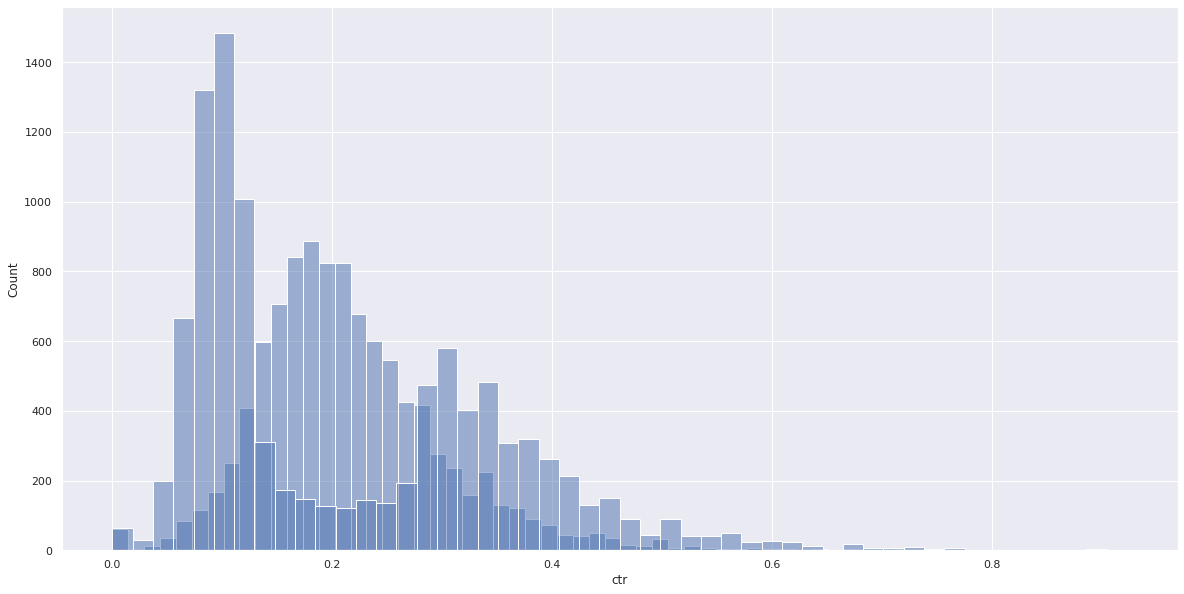

In [8]:
# гистограмма ctr по группам

sns.set(rc={'figure.figsize':(20,10)})

sns.histplot(data = users_1_group_df, x='ctr', alpha=0.5, kde=False, bins = 50)
sns.histplot(data = users_2_group_df, x='ctr', alpha=0.5, kde=False, bins = 50)

получилось не очень красиво, но, в целом, понятно

пробую t-test немного иначе:

In [9]:
# Повторная проверка (для себя)

q = """
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (1,2)
GROUP BY
    exp_group,
    user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

#T-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

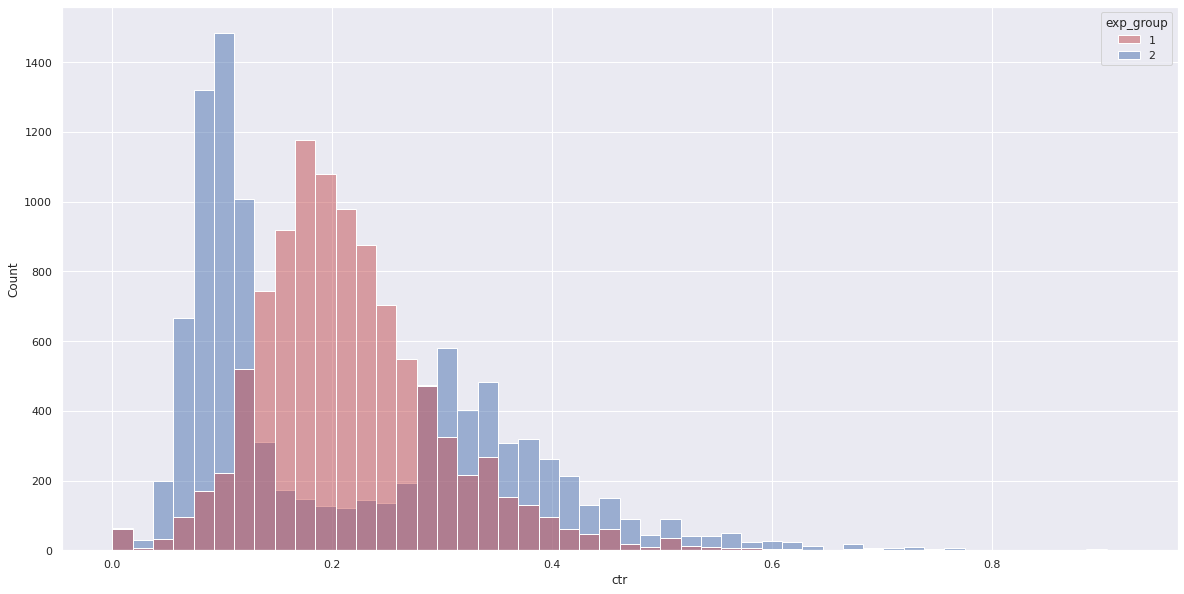

In [10]:
groups = sns.histplot(data = df,
                      x='ctr',
                      hue='exp_group',
                      palette = ['r', 'b'], alpha=0.5,
                      kde=False, bins = 50)

Так гораздо красивее.  

**Итак, в контрольной группе (1) унимодальное нормальное распределение ctr. В экспериментальной группе (2) бимодальное распределение ctr. Выглядит так, будто из-за нового алгоритма рекомендаций часть пользователей в группе 2 стали "лайкать" чаще, а другая часть пользователей - реже.  
При этом t-тест показал p-уровень значимости ~0.475, нулевая гипотеза не отклонена.**

## тест Манна-Уитни

In [11]:
t_M_U = stats.mannwhitneyu(users_1_group_df.ctr, users_2_group_df.ctr)
t_M_U

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

**Критерий Манна-Уитни показывает, что есть значимые различия в распределении CTR между группами 1 и 2.**

## T-test из кликхауса

In [12]:
# проба t-теста из кликхауса

q_ttest_clickh = """
WITH welchTTest(ctr, exp_index) as ttest
SELECT
    tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM 
    (SELECT
            exp_group,
            CASE
            WHEN exp_group = 1 THEN 0
            ELSE 1
            END AS exp_index,
            user_id,
            SUM(action = 'like') as likes,
            SUM(action = 'view') as views,
            likes/views as ctr
     FROM 
            {db}.feed_actions
    WHERE 
            toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
            AND exp_group in (1,2)
    GROUP BY
            exp_group,
            user_id) AS sq1
"""

ttest_clickh = pandahouse.read_clickhouse(q_ttest_clickh, connection=connection)

ttest_clickh

,statistic,p_value
0,0.709439,0.478062


**t-тест из кликхауса показывает p-value ~0,478, что очень близко к полученному ранее 0,475.**

## Тест Манна-Уитни из кликхауса

In [13]:
# проба теста Манна-Уитни из кликхауса

q_MWtest_clickh = """
WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw
SELECT
    tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM
    (SELECT
            exp_group,
            CASE
            WHEN exp_group = 1 THEN 0
            ELSE 1
            END AS exp_index, 
            user_id, 
            SUM(action = 'like') as likes,
            SUM(action = 'view') as views,
            likes/views as ctr
     FROM
            {db}.feed_actions
     WHERE
             toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
             AND exp_group in (1,2)
     GROUP BY
             exp_group,
             user_id) AS sq2
"""

MWtest_clickh = pandahouse.read_clickhouse(q_MWtest_clickh, connection=connection)

MWtest_clickh

,statistic,p_value
0,56601260.5,1.655343e-13


**P-value (1,6e-13) отличается от полученного ранее значения (6,04e-56), но все еще менее 0,05 и показывает, что есть значимые различия в распределении CTR между группами 1 и 2.**

## Сглаженный CTR

попробуем t-тест на сглаженном CTR

In [14]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

<AxesSubplot:xlabel='ctr', ylabel='Count'>

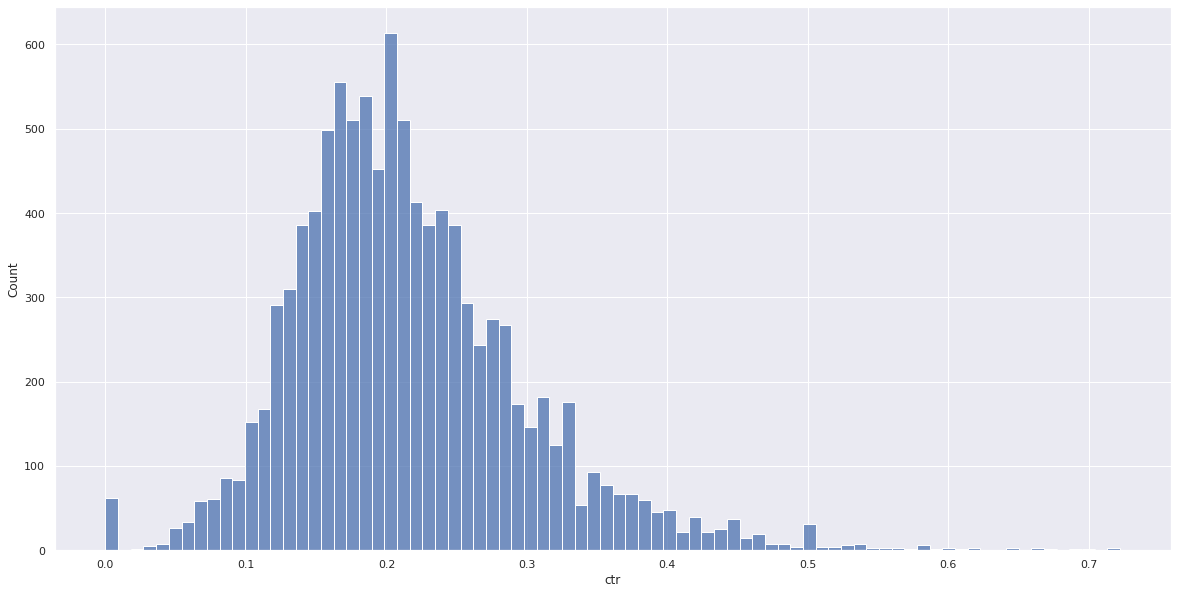

In [15]:
q_smoothed_ctr = """
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (1,2)
GROUP BY
    exp_group,
    user_id
"""
smoothed_ctr_df = pandahouse.read_clickhouse(q_smoothed_ctr, connection=connection)
global_ctr_1 = smoothed_ctr_df[smoothed_ctr_df.exp_group == 1].likes.sum()/smoothed_ctr_df[smoothed_ctr_df.exp_group == 1].views.sum()
global_ctr_2 = smoothed_ctr_df[smoothed_ctr_df.exp_group == 2].likes.sum()/smoothed_ctr_df[smoothed_ctr_df.exp_group == 2].views.sum()

group1 = smoothed_ctr_df[smoothed_ctr_df.exp_group == 1].copy()

sns.histplot(group1.ctr, kde = False)

**Распределение CTR в группе 1.**

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

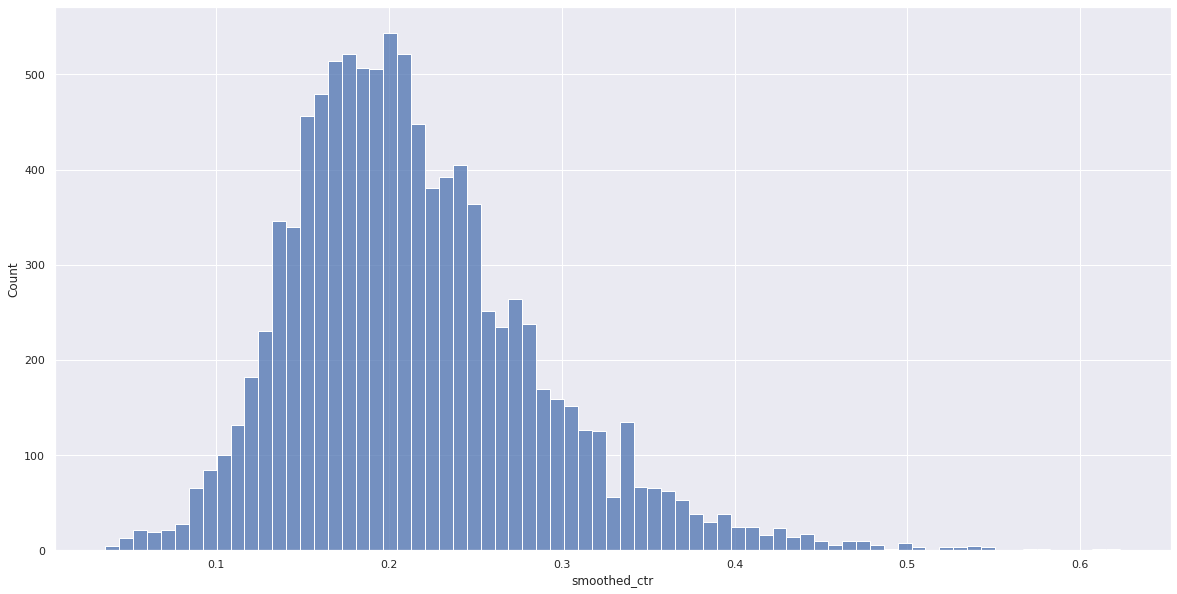

In [16]:
group1['smoothed_ctr'] = smoothed_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smoothed_ctr, kde = False)

**Сглаженное распределение CTR в группе 1.  
Видно различие (отсутствие локальных пиков) по краям и в центре.**

<AxesSubplot:xlabel='ctr', ylabel='Count'>

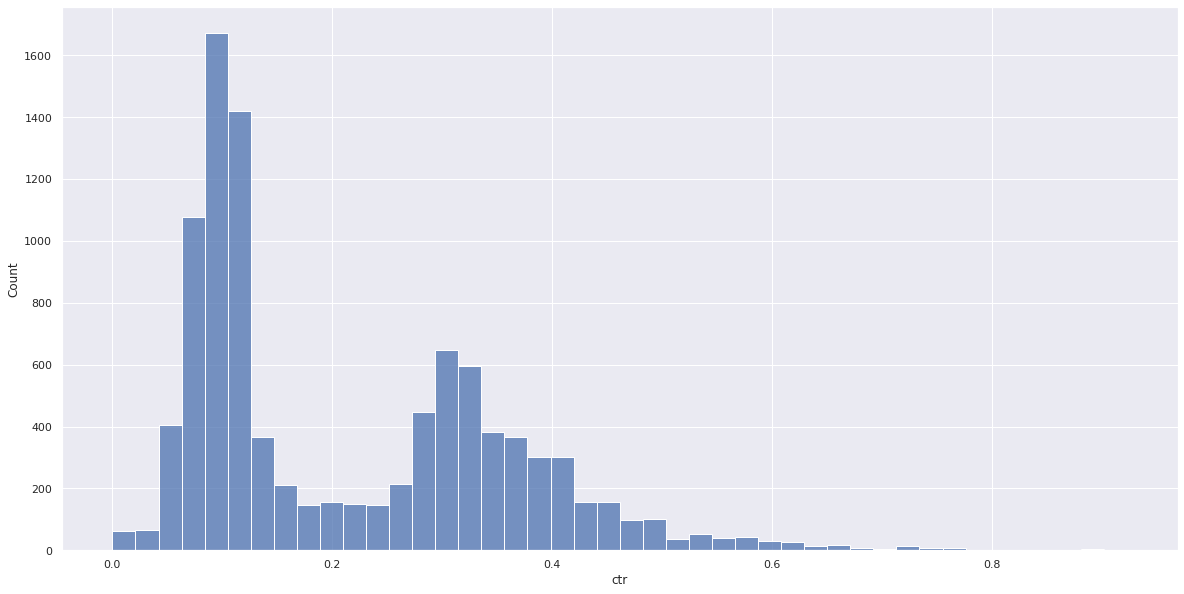

In [17]:
group2 = smoothed_ctr_df[smoothed_ctr_df.exp_group == 2].copy()

sns.histplot(group2.ctr,kde = False)

**Распределение CTR в группе 2.**

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

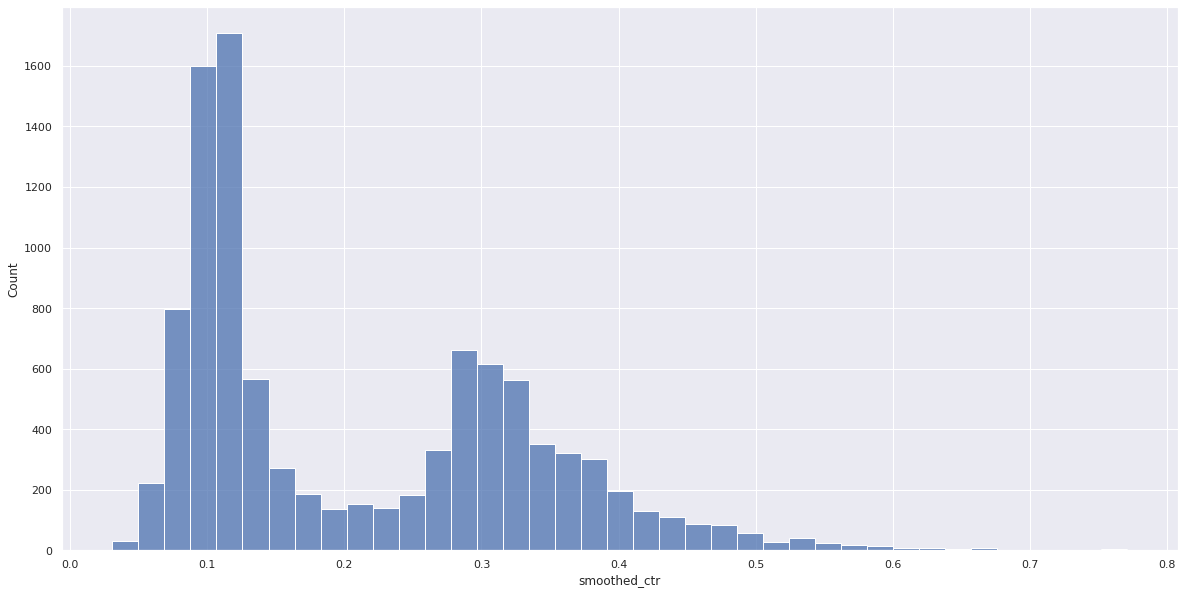

In [18]:
group2['smoothed_ctr'] = smoothed_ctr_df.apply(lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smoothed_ctr, kde = False)

**Сглаженное распределение CTR в группе 2.  
Едва различимые отличия.**

In [19]:
t_test_smooth = stats.ttest_ind(group1.smoothed_ctr, group2.smoothed_ctr, equal_var=False)
t_test_smooth

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

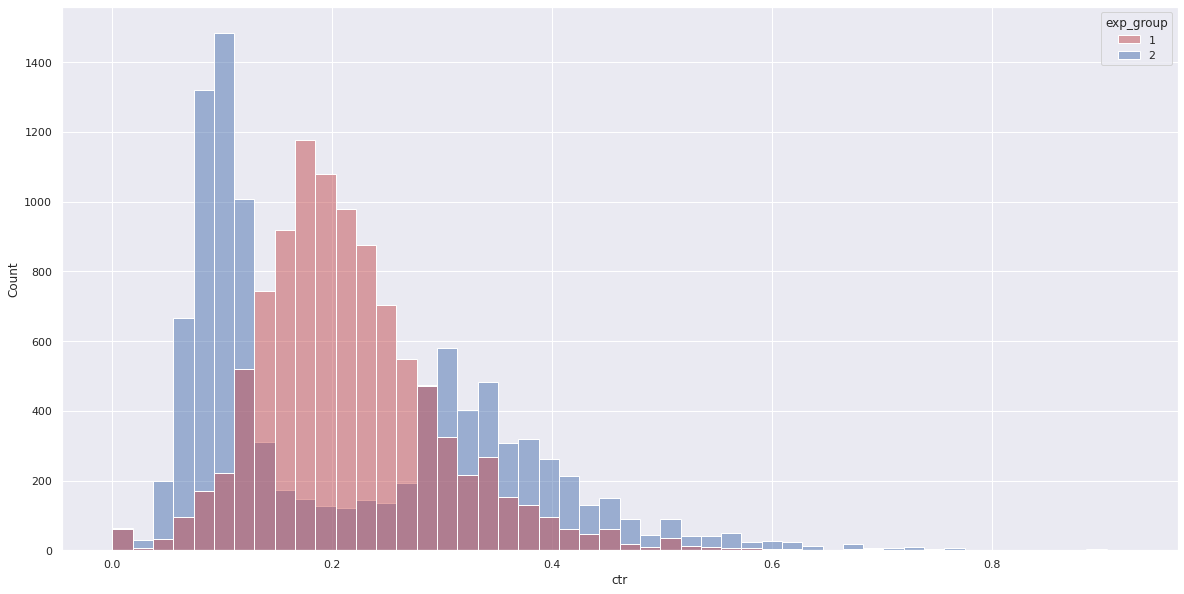

In [20]:
smoothed_ctr_df_true = group1.append(group2, ignore_index=True)

groups_smooth = sns.histplot(data = smoothed_ctr_df_true,
                             x='ctr',
                             hue='exp_group',
                             palette = ['r', 'b'],
                             kde=False, bins=50)

**На гистограмме мы видим примерно ту же картину, что и раньше.  
При использовании t-теста на сглаженном CTR мы получили p-уровень значимости 0,02 (против 0,475 ранее) и в этот раз можем отклонить нулевую гипотезу.**

## Пуассоновский бутстреп

In [21]:
# функция для расчета глобальных CTR для групп 1 и 2

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

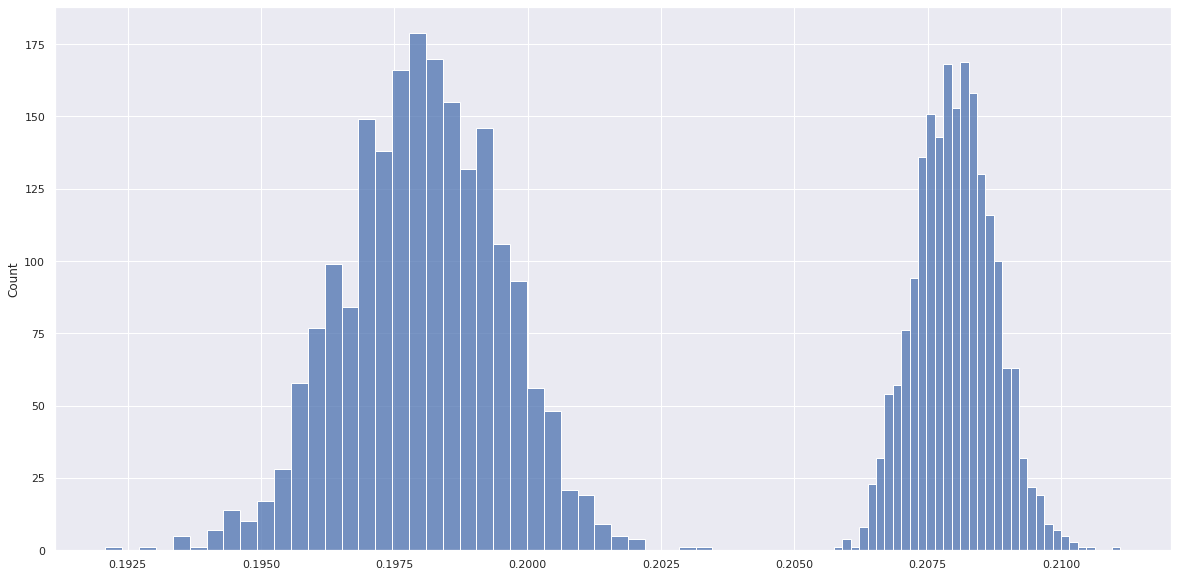

In [37]:
# делаем запрос в БД, считаем "глобальные CTR" для групп, строим гистограммы распределения

q_pois_boot = """
SELECT
    exp_group,
    user_id,
    SUM(action = 'like') as likes,
    SUM(action = 'view') as views,
    likes/views as ctr
FROM
    {db}.feed_actions
WHERE
    toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
    AND exp_group in (1,2)
GROUP BY
    exp_group,
    user_id
"""

df_pois_boot = pandahouse.read_clickhouse(q_pois_boot, connection=connection)
likes1 = df_pois_boot[df_pois_boot.exp_group == 1].likes.to_numpy()
views1 = df_pois_boot[df_pois_boot.exp_group == 1].views.to_numpy()
likes2 = df_pois_boot[df_pois_boot.exp_group == 2].likes.to_numpy()
views2 = df_pois_boot[df_pois_boot.exp_group == 2].views.to_numpy()
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1)
sns.histplot(ctr2)

**Видна четкая разница между "глобальными CTR" в 1 и 2 группах, распределения не пересекаются. Кроме того группа 2 демонстрирует больший разброс значений "глобального CTR", чем группа 1.**

<AxesSubplot:ylabel='Count'>

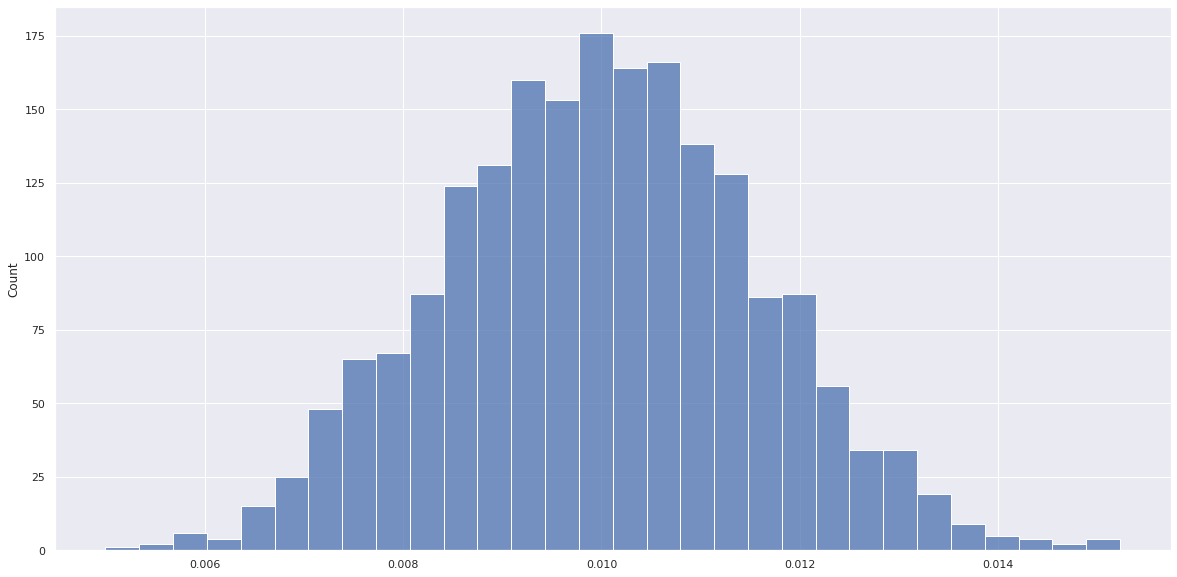

In [33]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

**При этом "глобальные CTR" контрольной группы (1) больше, чем экспериментальной.**

In [38]:
# t-тест можно и не делать, но все же

t_pois_boot = stats.ttest_ind(ctr1, ctr2, equal_var=False)
t_pois_boot

Ttest_indResult(statistic=273.05374958433435, pvalue=0.0)

**Нулевая гипотеза отклонена**

## Бакетное преобразование

In [35]:
# делаем бакетное преобразование

q_bucket = """
SELECT
    exp_group,
    bucket,
    SUM(likes)/SUM(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM 
    (SELECT 
            exp_group,
            xxHash64(user_id)%50 as bucket,
            user_id,
            SUM(action = 'like') as likes,
            SUM(action = 'view') as views,
            likes/views as ctr
     FROM
            {db}.feed_actions
     WHERE 
            toDate(time) BETWEEN '2023-01-31' AND '2023-02-06'
            AND exp_group in (1,2)
     GROUP BY
             exp_group,
             bucket,
             user_id) AS sq3
GROUP BY
    exp_group,
    bucket
"""
df_bucket = pandahouse.read_clickhouse(q_bucket, connection=connection)

In [36]:
#тест Манна-Уитни

stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [40]:
#t-тест
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr,
                df_bucket[df_bucket.exp_group == 2].bucket_ctr,
                equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

**Т-тест и тест Манна-Уитни показывают p-value менее 0,05. Нулевая гипотеза отклонена.**

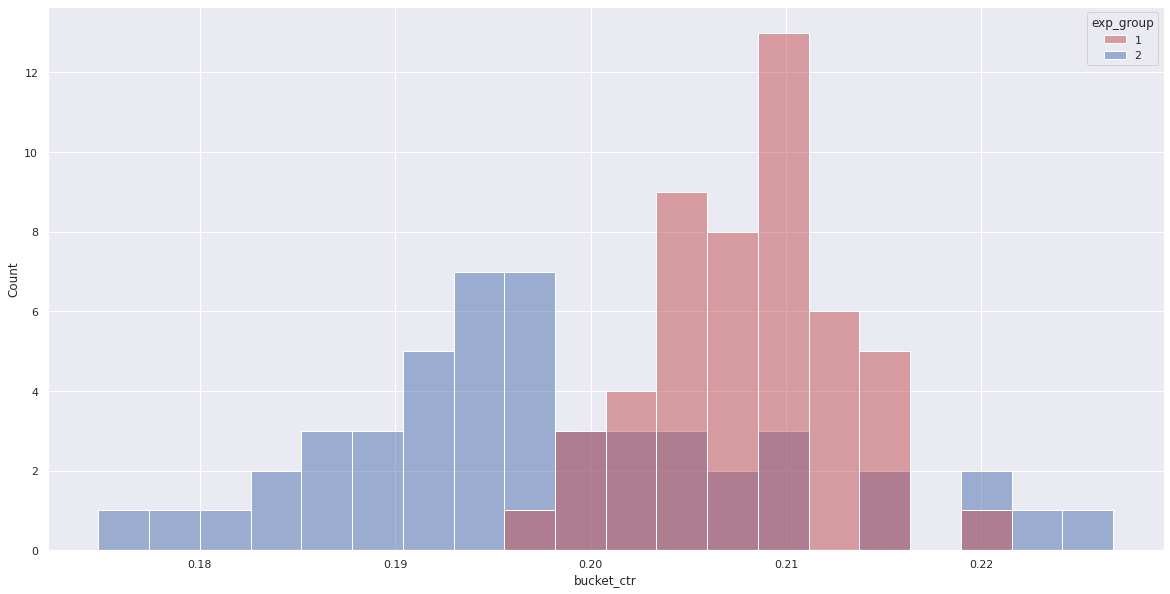

In [41]:
# Рисуем распределение бакетных CTR

groups_bucket = sns.histplot(data = df_bucket,
                             x='bucket_ctr',
                             hue='exp_group',
                             palette = ['r', 'b'],
                             kde=False, bins = 20)

In [42]:
df_bucket.describe()

,exp_group,bucket,bucket_ctr,ctr9
count,100.000000,100.00000,100.000000,100.000000
mean,1.500000,24.50000,0.203191,0.364456
std,0.502519,14.50357,0.009974,0.047095
min,1.000000,0.00000,0.174810,0.285714
25%,1.000000,12.00000,0.196330,0.323037
50%,1.500000,24.50000,0.205072,0.364919
75%,2.000000,37.00000,0.209913,0.400000
max,2.000000,49.00000,0.226729,0.467742


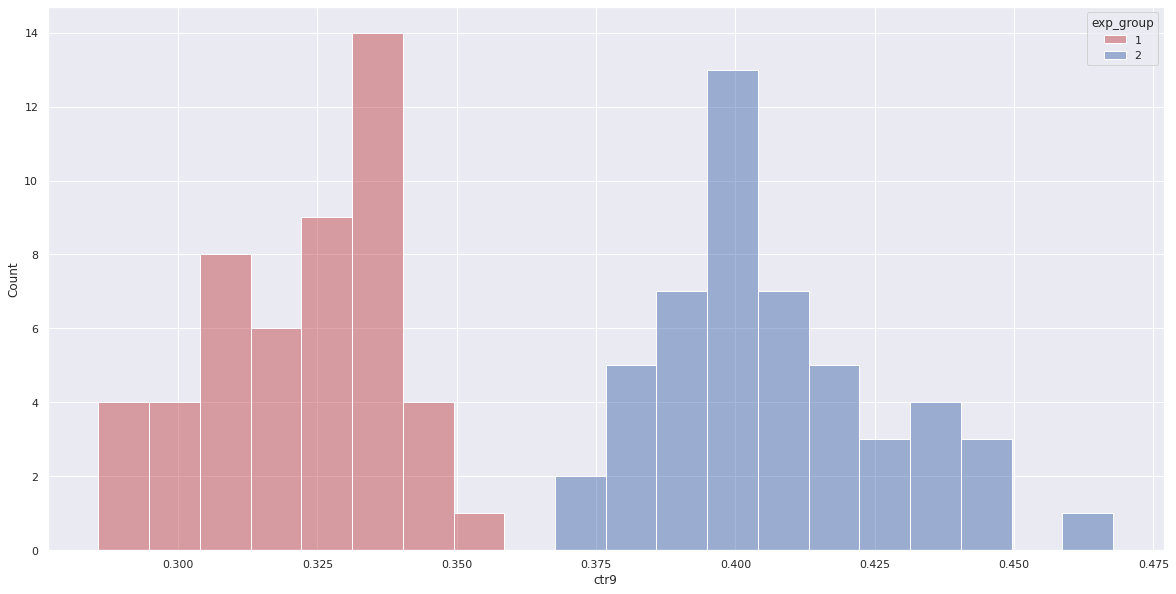

In [43]:
# Рисуем распределение бакетных CTR с квантилем 0.9

groups_bucket = sns.histplot(data = df_bucket,
                             x='ctr9',
                             hue='exp_group',
                             palette = ['r', 'b'],
                             kde=False, bins = 20)

**Как и в случае с "глобальными CTR", распределения 0.9-квантильных CTR не пересекаются.** 

In [44]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].ctr9,
                df_bucket[df_bucket.exp_group == 2].ctr9,
                equal_var = False)

Ttest_indResult(statistic=-23.214341215937406, pvalue=1.2945537024964474e-40)

**Ожидаемо, p-value много меньше 0,05. Нулевая гипотеза отклонена.**

## Обсуждение результатов

**Все тесты, кроме t-теста на сырых данных, показали p-value менее 0,05, что позволяет отклонить нулевую гипотезу. После обработки данных t-тест также стал показывать р-уровень значимости менее 0,05.  
Графический анализ распределений CTR показывает унимодальное нормальное распределение ctr в контрольной группе (1) и бимодальное распределение ctr в экспериментальной группе (2). Выглядит так, будто из-за нового алгоритма рекомендаций часть пользователей в группе 2 стали "лайкать" чаще, а другая часть пользователей - реже. Причем тех, кто "лайкает" меньше стало больше.  
Раскатывать новый алгоритм на всех новых пользователей однозначно не стоит.**